In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.colors import ListedColormap, BoundaryNorm
import shapely.geometry as sgeom
from shapely.geometry import Point
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.lines as mlines
import Topography

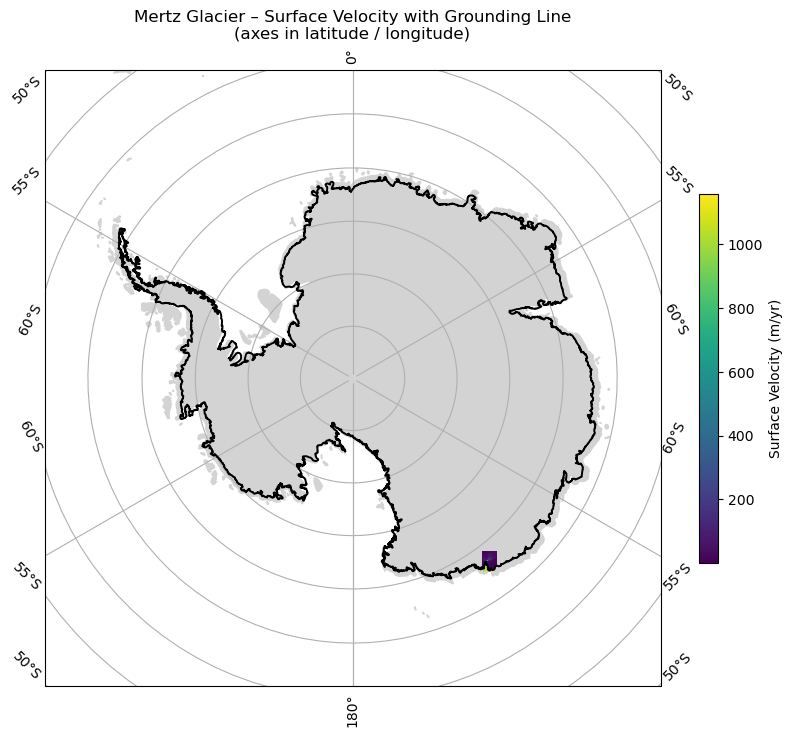

In [8]:
xmin_ant = -3333250
xmax_ant = 3333250
ymin_ant = -3333250
ymax_ant = 3333250

xmin, xmax = 1382750/1000, 1543250/1000
ymin, ymax = -2077750/1000, -1850250/1000

path = "/Users/maheerbansari/Downloads/CURE_Geophysical/DEMOGORGN data/moa2014_groundingline_v01/moa2014_grounding_line_v01.shp"
gl = gpd.read_file(path)
glx,gly = gl.geometry[0].exterior.xy
glau = gl.geometry.clip_by_rect(xmin_ant, ymin_ant, xmax_ant, ymax_ant)
glaux, glauy = glau[0].exterior.xy


# Extract all polygons into lists of x/y coordinates
glaux_list = []
glauy_list = []

for geom in glau.geometry:
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        glaux_list.append(np.array(x))
        glauy_list.append(np.array(y))
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            x, y = poly.exterior.xy
            glaux_list.append(np.array(x))
            glauy_list.append(np.array(y))


df = pd.read_csv('MertzGlacierDataGridded.csv')
xx, yy = np.meshgrid(np.unique(df.x), np.unique(df.y))

velocity_x = df['velx'].values.reshape(xx.shape)
velocity_y = df['vely'].values.reshape(xx.shape)
surface_mass_balance = df['smb'].values.reshape(xx.shape) #smb = surface mass balance
surface_elevation_change = df['dhdt'].values.reshape(xx.shape) #dhdt = surface elevation change rate
velocity_magnitude = np.sqrt(velocity_x**2 + velocity_y**2)
bedmap_surf = df['surf'].values.reshape(xx.shape)

# --- CARTOPY FIGURE SETUP ---
fig = plt.figure(figsize=(10, 8))

# Antarctic Polar Stereographic
proj = ccrs.SouthPolarStereo()

ax = plt.axes(projection=proj)

# Set extent using stereographic x/y coordinates (meters)
ax.set_extent([-3.3e6, 3.3e6, -3.3e6, 3.3e6], crs=proj)

# Add coastlines + background context
ax.add_feature(cfeature.LAND, color="lightgray")
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)


# --- PLOT VELOCITY MAGNITUDE ---
img = ax.pcolormesh(
    xx, yy, velocity_magnitude,
    cmap="viridis",
    transform=proj,
    shading='auto'
)


# --- OVERLAY GROUNDING LINE (already EPSG:3031) ---
for gx, gy in zip(glaux_list, glauy_list):
    ax.plot(gx, gy, color='black', linewidth=1.4, transform=proj)


# --- COLORBAR ---
cbar = plt.colorbar(img, ax=ax, shrink=0.6)
cbar.set_label("Surface Velocity (m/yr)")

plt.title("Mertz Glacier – Surface Velocity with Grounding Line\n(axes in latitude / longitude)")
plt.show()

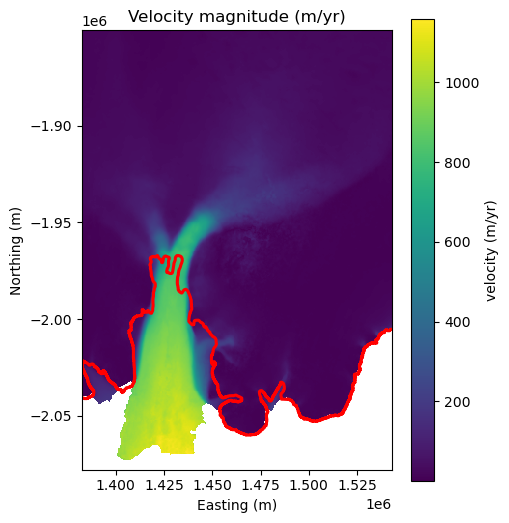

In [9]:
# calculate velocity magnitude
vel_mag = velocity_magnitude

# bounding box of your plot area
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

# plot velocity
plt.figure(figsize=(5, 6))
p = plt.pcolormesh(xx, yy, vel_mag, shading='auto')

# colorbar
cbar = plt.colorbar(p)
cbar.set_label("velocity (m/yr)")

# ---- CROP GROUNDING LINE TO STUDY AREA ----
for gx, gy in zip(glaux_list, glauy_list):

    # create inside-mask (True where grounding line falls inside domain)
    inside = (gx >= xmin) & (gx <= xmax) & (gy >= ymin) & (gy <= ymax)

    if np.any(inside):
        plt.plot(gx[inside], gy[inside], color='red', linewidth=2.2)  # <<< CHANGED HERE

plt.axis('scaled')
plt.title('Velocity magnitude (m/yr)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.show()

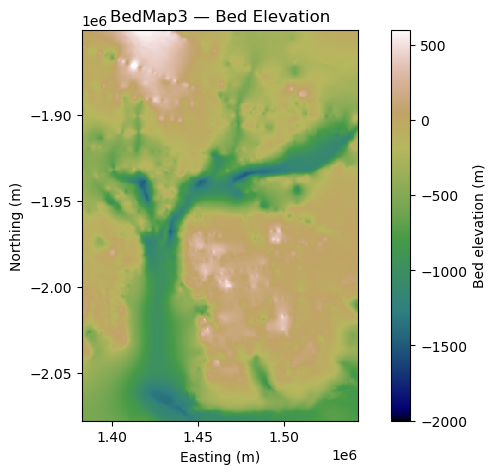

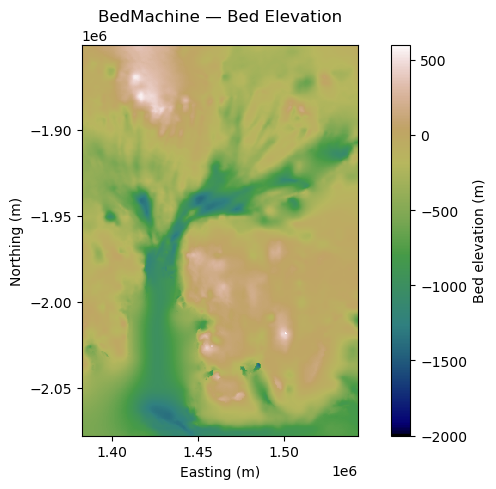

In [10]:
plt.figure(figsize=(5, 5))
bedmap_bed=df['bedmap_bed'].values.reshape(xx.shape)
p1 = plt.pcolormesh(xx, yy, bedmap_bed, cmap='gist_earth',
                    shading='nearest', vmin=-2000, vmax=600)

cbar = plt.colorbar(p1)
cbar.set_label("Bed elevation (m)")

plt.axis('scaled')
plt.title("BedMap3 — Bed Elevation")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
bm_bed=df['bm_bed'].values.reshape(xx.shape)
p2 = plt.pcolormesh(xx, yy, bm_bed, cmap='gist_earth',
                    shading='nearest', vmin=-2000, vmax=600)

cbar = plt.colorbar(p2)
cbar.set_label("Bed elevation (m)")

plt.axis('scaled')
plt.title("BedMachine — Bed Elevation")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [ ]:

# --- Compute ice thickness ---
surf = df['surf'].values.reshape(xx.shape)
bed = df['bed'].values.reshape(xx.shape)
ice_thickness = surf - bed

# --- Initialize mask ---
mask = np.zeros_like(bed, dtype=int)

# --- Handle NaNs as ocean ---
nan_mask = np.isnan(surf) | np.isnan(bed)
mask[nan_mask] = 4  # ocean

# --- Classification logic ---
mask[(ice_thickness > 10) & (bed > 0)] = 1       # grounded ice
mask[(ice_thickness > 10) & (bed <= 0)] = 2      # floating ice shelf
mask[(ice_thickness <= 10) & (bed > 0)] = 3      # ice-free land
mask[(ice_thickness <= 10) & (bed <= 0) & (~nan_mask)] = 4  # open ocean

# --- Initialize mask ---
mask = np.zeros_like(bed, dtype=int)

# --- Create a unified grounding line polygon ---
grounding_poly = glau.unary_union  # combines all polygons



# --- Loop over grid points and classify ---
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        pt = Point(xx[i,j], yy[i,j])
        if grounding_poly.contains(pt):
            # inside grounding line: grounded ice
            mask[i,j] = 1
        elif bed[i,j] <= 0:
            # outside grounding line, bed below sea: ocean
            mask[i,j] = 4
        elif bed[i,j] > 0 and (surf[i,j] - bed[i,j]) > 10:
            # floating ice shelf above bed: floating
            mask[i,j] = 2
        elif bed[i,j] > 0:
            # ice-free land
            mask[i,j] = 3

            
# --- Colormap ---
colors = [
    'white',        # background
    '#a6611a',      # grounded ice (brownish)
    '#74add1',      # floating shelf (light blue)
    '#d9d9d9',      # ice-free land (gray)
    '#023858'       # ocean (dark blue)
]
labels = ['(none)', 'Grounded Ice', 'Floating Ice Shelf', 'Ice-Free Land', 'Ocean']

cmap = ListedColormap(colors)
norm = BoundaryNorm([0,1,2,3,4,5], cmap.N)
plt.figure(figsize=(9,7))
plt.pcolormesh(xx/1000, yy/1000, mask, cmap=cmap, norm=norm, shading='auto')

# Overlay grounding line (cropped to study area)
for gx, gy in zip(glaux_list, glauy_list):
    plt.plot(gx/1000, gy/1000, color='black', linewidth=1.2, alpha=0.7)

# Overlay bed contours for reference
contour_levels = np.arange(np.nanmin(bed), np.nanmax(bed), 200)
cs = plt.contour(xx/1000, yy/1000, bed, levels=contour_levels, colors='k', linewidths=0.6, alpha=0.4)
plt.clabel(cs, fmt='%d', fontsize=7, inline=True)

plt.axis('scaled')
plt.title('Surface Type Mask with Grounding Line and Bed Contours')
plt.xlabel('Easting (km)')
plt.ylabel('Northing (km)')

# Legend
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(1,5)]
plt.legend(handles=patches, loc='upper right', fontsize=9)

plt.show()
print(xx.min()/1000, xx.max()/1000)
print(yy.min()/1000, yy.max()/1000)
print(np.nanmin(surf-bed), np.nanmax(surf-bed))

/var/folders/1x/4c8mjfmx43n5v6fq6xlrc7200000gn/T/ipykernel_64092/2576696872.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grounding_poly = glau.unary_union  # combines all polygons
